In [1]:
import data.data_processor as dp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def csv_load(video_sample, person):
    """"""
    "Read Data"
    path = f'data/saved_data/{person}/{video_sample}.csv'
    
    df_loaded = pd.read_csv(path)
    time_loaded = df_loaded['Time']
    g_signal_loaded = df_loaded['Signal_1']
    
    "Process Signal"
    xp, interp_signal, fs = dp.process_time(time_loaded,g_signal_loaded)
    
    signal = dp.data_process(interp_signal, 10, int(fs*3), fs, fs)
    
    "Apply Features"    
    fund_values = dp.tsfel_features_fs('fundamental_frequency', signal, int(fs*2), 2, fs)
    
    autocorr_values = dp.tsfel_features('autocorr', signal, int(fs*2), 2)
    
    pk_values = dp.tsfel_features('pk_pk_distance', signal,int(fs*2),2)
    
    std_values = dp.tsfel_features('calc_std', signal,int(fs*2),2)
    
    zero_values = dp.tsfel_features('zero_cross', signal, int(fs*2), 2)
    
    "Create Dataframe"
    df_result = pd.DataFrame()
    df_result['Fund Freq'] = fund_values
    df_result['Autocorr'] = autocorr_values
    df_result["Pk to Pk"] = pk_values
    df_result["Std"] = std_values
    df_result['Zero Cross'] = zero_values
    
    return df_result

In [3]:
"Load Signals"
df_p = csv_load('video_p_normal_nat', 'Pedro')
df_p_s = csv_load('video_p_stress_nat', 'Pedro')

df_v = csv_load('video_v_normal_nat', 'Vasco')
df_v_s = csv_load('video_v_stress_nat', 'Vasco')

df_l = csv_load('video_l_normal', 'Leonor')
df_l_s = csv_load('video_l_stress', 'Leonor')

In [4]:
"Concatenate Data"
df = pd.concat([df_p, df_p_s, df_v, df_v_s, df_l, df_l_s],
               keys=['Normal','Stress', 'Normal', 'Stress', 'Normal', 'Stress'])
df = df.reset_index()
df = df.drop('level_1', axis = 1)
df.columns = ['Type', 'Fund Freq', 'Autocorr', 'Pk to Pk', 'Std', 'Zero Cross']
df

,Type,Fund Freq,Autocorr,Pk to Pk,Std,Zero Cross
0,Normal,0.500361,0.007884,0.004699,0.001045,0
1,Normal,0.500361,0.007294,0.005578,0.001342,0
2,Normal,1.000723,0.007588,0.005097,0.000940,0
3,Normal,0.500361,0.007823,0.004417,0.001254,0
4,Normal,0.500361,0.007353,0.004033,0.001081,0
...,...,...,...,...,...,...
187,Stress,1.000306,0.010343,0.006788,0.001733,0
188,Stress,0.500153,0.016806,0.008588,0.002600,0
189,Stress,0.500153,0.015796,0.007702,0.001816,0
190,Stress,1.500459,0.013662,0.008160,0.001978,0


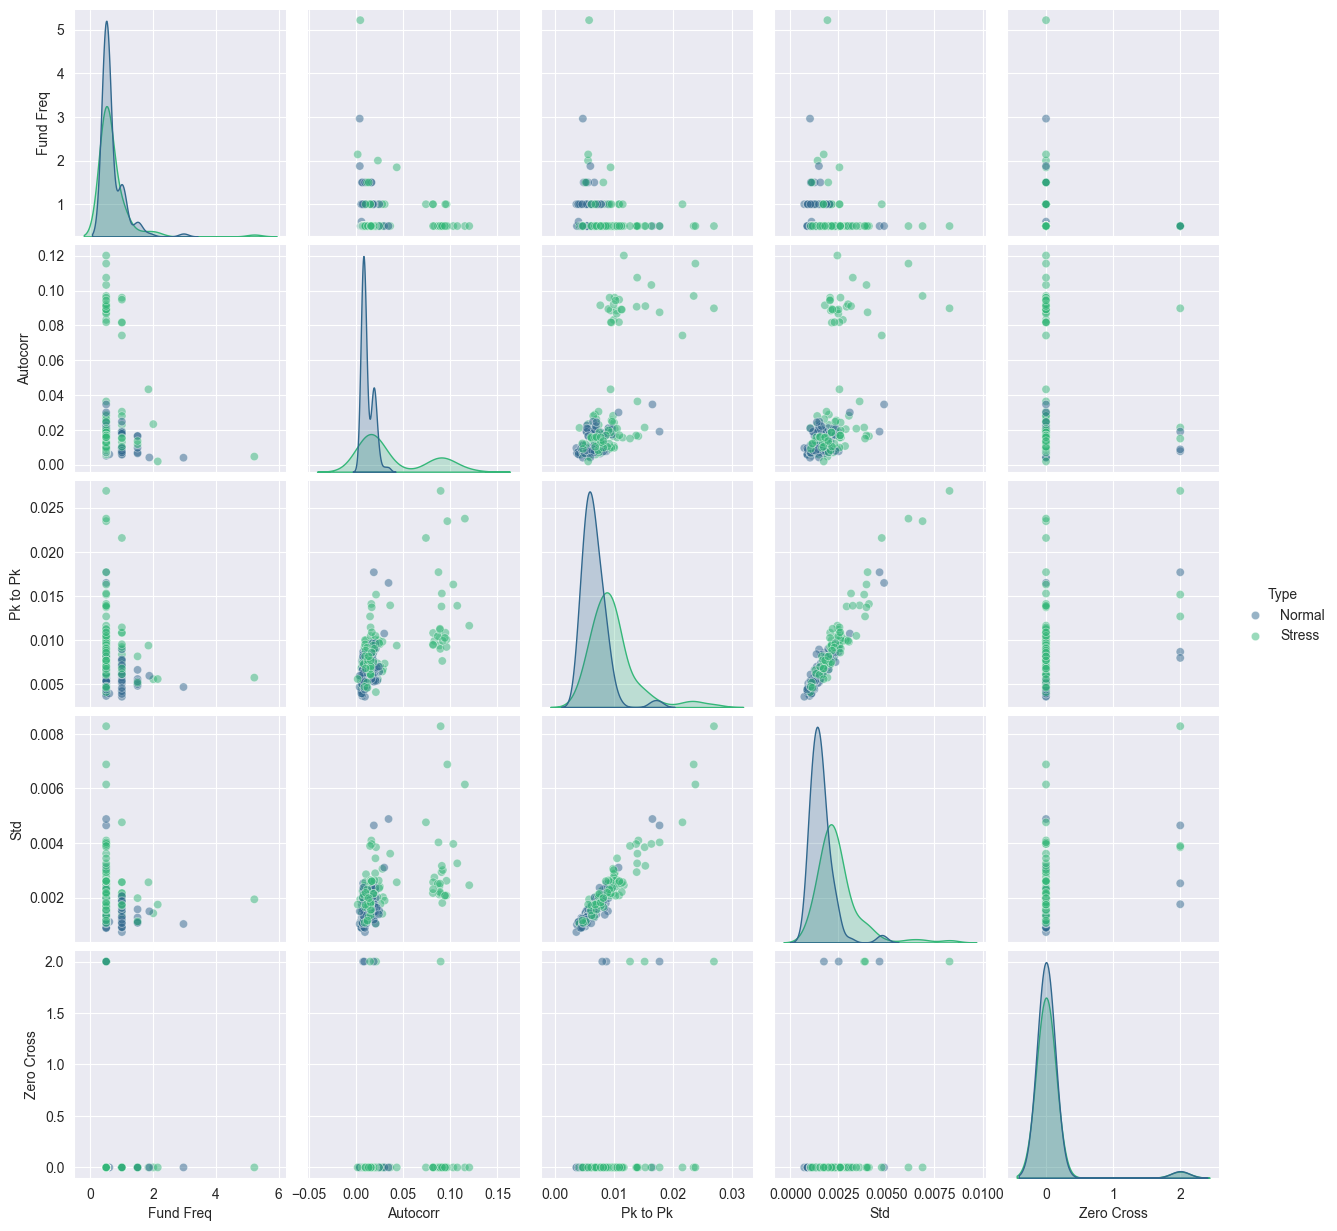

In [5]:
sns.pairplot(df, hue='Type', palette='viridis', plot_kws={'alpha': 0.5})

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Select Features
features_cols = ['Fund Freq', 'Autocorr', 'Pk to Pk', 'Std', 'Zero Cross']

# Features (X) e Labels (y)
X = df[features_cols]
y = df['Type']

# Randomize the test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

# Create pipeline object
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Train the model
pipe.fit(X_train, y_train)

# Test the model
predictions = pipe.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'model accuracy: {accuracy}')

model accuracy: 0.8125


model accuracy: 0.8125


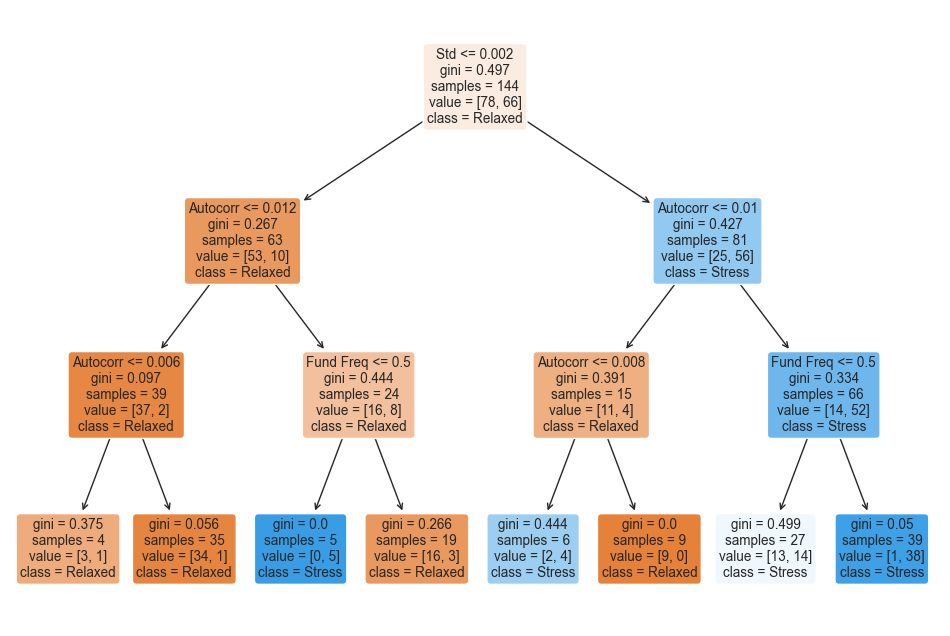

In [8]:
# Select Features
features_cols = ['Fund Freq', 'Autocorr', 'Pk to Pk', 'Std', 'Zero Cross']  

# Features (X) e Labels (y)
X = df[features_cols]
y = df['Type']

# Randomize the test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

# Create model and adjust the tree max_deph
model = DecisionTreeClassifier(max_depth=3)

# Train the model
model = model.fit(X_train, y_train)

# Test the model
predictions = model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'model accuracy: {accuracy}')

# Plot the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=features_cols, class_names=['Relaxed', 'Stress'], filled=True, rounded=True)
plt.show()

Number of windows: 192
model accuracy: 0.8958333333333334


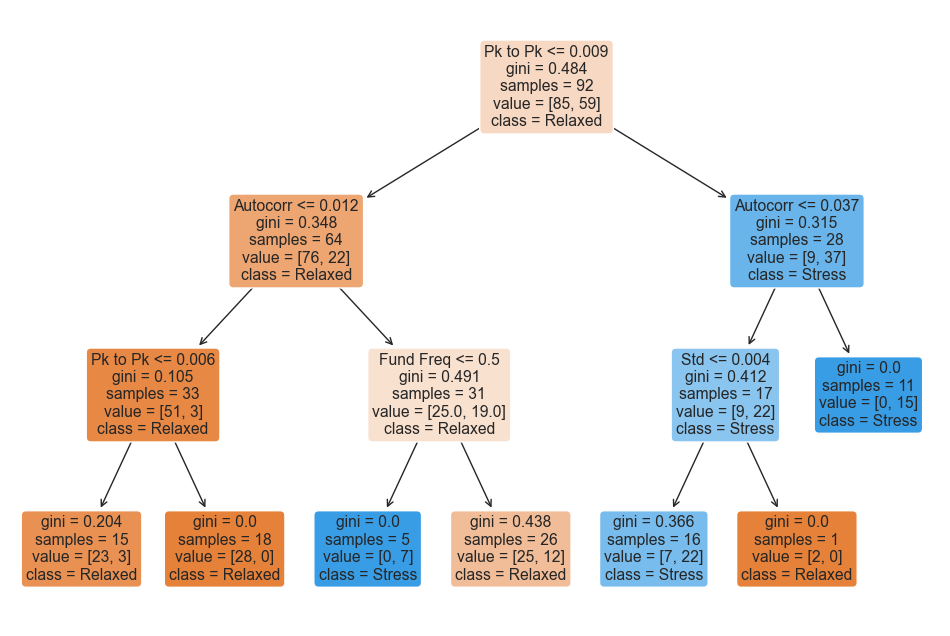

In [9]:
# Select Features
features_cols = ['Fund Freq', 'Autocorr', 'Pk to Pk', 'Std', 'Zero Cross']

# Features (X) e Labels (y)
X = df[features_cols]
y = df['Type']
print(f'Number of windows: {len(y)}')

# Randomize the test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

# Create model and adjust the tree max_deph and the number of estimators
model = RandomForestClassifier(n_estimators=10, random_state=3, max_depth=3)

# Train the model
model = model.fit(X_train, y_train)

# Test the model
predictions = model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'model accuracy: {accuracy}')

# Plot one Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(model.estimators_[1], feature_names=features_cols,   class_names=['Relaxed', 'Stress'], filled=True, rounded=True)
plt.show()

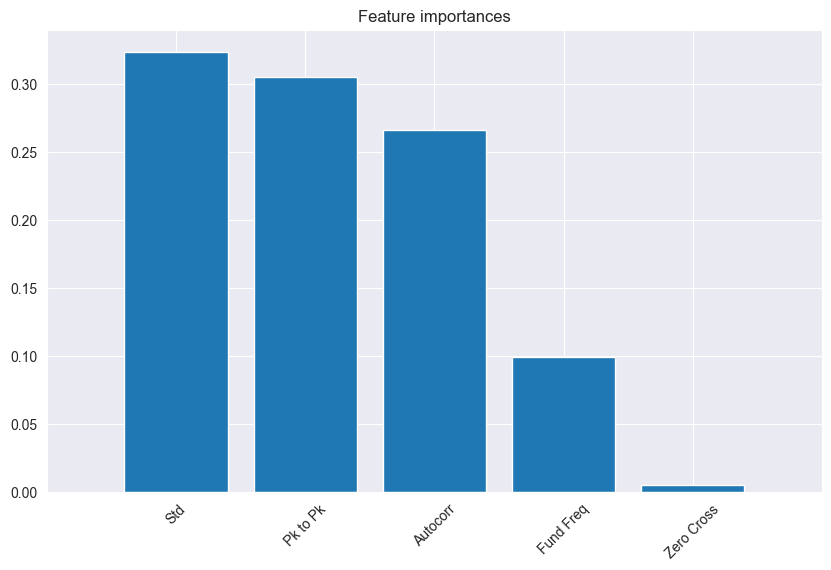

In [10]:
# Get the importance of features 
importances = model.feature_importances_

# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the different importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features_cols[i] for i in indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()